In [1]:
import re
import nltk
import string
import gensim
import pickle
import random
import pyLDAvis
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pyLDAvis.gensim_models as gensimvis

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, ImageColorGenerator
from scipy.signal import argrelextrema
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from gensim import corpora
from PIL import Image

warnings.filterwarnings("ignore")
sns.set()
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yuliaafletunova/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Analyse StackOverflow Questions

Query: 
~~~~sql
SELECT 
  TagName,
  Posts.*
  FROM Tags 
  JOIN PostTags ON Tags.Id = PostTags.TagId 
  JOIN Posts ON Posts.Id = PostId
WHERE Tags.TagName = 'ide-1'
~~~~

Source: https://data.stackexchange.com/stackoverflow/query/edit/1658631#resultSets

In [2]:
so_posts_raw = pd.read_csv("data/tagged_questions.csv")
so_posts_raw.head()

,Unnamed: 0,TagName,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,...,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
0,0,ide-1,25806432,1,25809370.0,NaN,2014-09-12 10:40:46,NaN,2,6155,...,2014-09-12 13:39:56,2014-09-25 12:20:14,Trouble with compiling in ide-1,<c++><c++11><ide-1>,2,10,1.0,NaN,NaN,CC BY-SA 3.0
1,1,ide-1,25829103,1,25831365.0,NaN,2014-09-14 00:45:57,NaN,3,5245,...,2014-09-14 07:59:58,2014-09-14 08:19:13,Executing make from cmake,<c++><makefile><cmake><ide-1>,1,1,1.0,NaN,NaN,CC BY-SA 3.0
2,2,ide-1,25834878,1,25836234.0,NaN,2014-09-14 15:27:43,NaN,19,25323,...,2018-09-05 23:45:36,2018-09-09 18:57:07,How do I change the working directory for my p...,<cmake><ide-1>,3,0,2.0,NaN,NaN,CC BY-SA 3.0
3,3,ide-1,25836027,1,28200869.0,NaN,2014-09-14 17:32:54,NaN,56,50346,...,2015-01-28 20:48:05,2016-01-15 17:22:50,Where does ide-1 store executable files?,<c++><cmake><ubuntu-14.04><company_name-ide><i...,2,1,11.0,NaN,NaN,CC BY-SA 3.0
4,4,ide-1,25863667,1,NaN,NaN,2014-09-16 08:09:48,NaN,0,894,...,NaN,2014-09-16 08:09:48,Building with CMake,<opencv><cmake><ide-1>,0,3,NaN,NaN,NaN,CC BY-SA 3.0


In [3]:
so_posts_raw = pd.read_csv("data/tagged_questions.csv")

posts_data = so_posts_raw.copy()

posts_data["CreationDate"] = pd.to_datetime(posts_data["CreationDate"])

posts_data["year"] = posts_data["CreationDate"].dt.year
posts_data["month"] = posts_data["CreationDate"].dt.to_period("M")

posts_data.head()

,Unnamed: 0,TagName,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,...,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,year,month
0,0,ide-1,25806432,1,25809370.0,NaN,2014-09-12 10:40:46,NaN,2,6155,...,Trouble with compiling in ide-1,<c++><c++11><ide-1>,2,10,1.0,NaN,NaN,CC BY-SA 3.0,2014,2014-09
1,1,ide-1,25829103,1,25831365.0,NaN,2014-09-14 00:45:57,NaN,3,5245,...,Executing make from cmake,<c++><makefile><cmake><ide-1>,1,1,1.0,NaN,NaN,CC BY-SA 3.0,2014,2014-09
2,2,ide-1,25834878,1,25836234.0,NaN,2014-09-14 15:27:43,NaN,19,25323,...,How do I change the working directory for my p...,<cmake><ide-1>,3,0,2.0,NaN,NaN,CC BY-SA 3.0,2014,2014-09
3,3,ide-1,25836027,1,28200869.0,NaN,2014-09-14 17:32:54,NaN,56,50346,...,Where does ide-1 store executable files?,<c++><cmake><ubuntu-14.04><company_name-ide><i...,2,1,11.0,NaN,NaN,CC BY-SA 3.0,2014,2014-09
4,4,ide-1,25863667,1,NaN,NaN,2014-09-16 08:09:48,NaN,0,894,...,Building with CMake,<opencv><cmake><ide-1>,0,3,NaN,NaN,NaN,CC BY-SA 3.0,2014,2014-09


In [4]:
print(
    "There are {} observations and {} features in the dataset. \n".format(
        posts_data.shape[0], posts_data.shape[1]
    )
)

There are 2628 observations and 27 features in the dataset. 



In [5]:
print(
    "The first post in the dataset was created in {} and the last one in {}".format(
        posts_data["month"].min(), posts_data["month"].max()
    )
)

The first post in the dataset was created in 2014-09 and the last one in 2022-10


## Number of questions by time

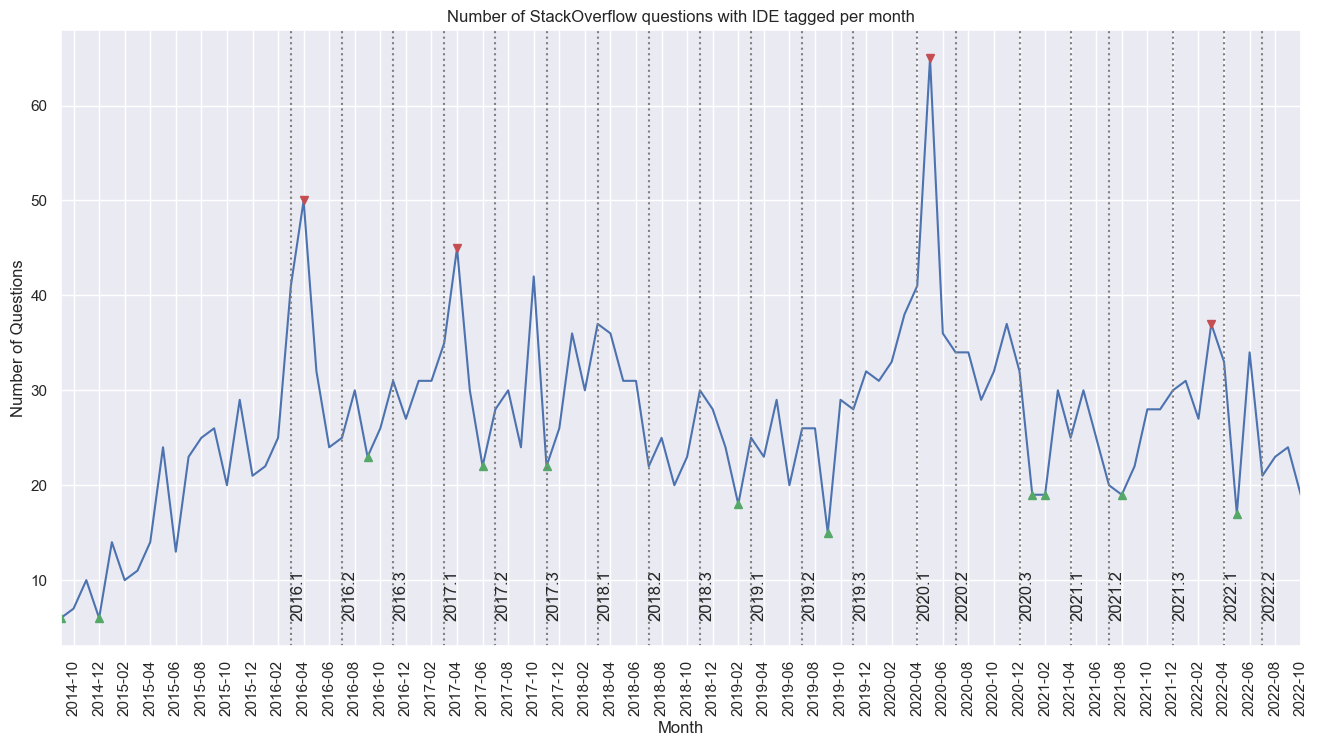

In [6]:
number_of_questions_per_month = posts_data.groupby("month")["Id"].count()

ilocs_min = argrelextrema(number_of_questions_per_month.values, np.less_equal, order=6)[
    0
]
ilocs_max = argrelextrema(
    number_of_questions_per_month.values, np.greater_equal, order=6
)[0]

releases = [
    ("2022-07", "2022.2"),
    ("2022-04", "2022.1"),
    ("2021-12", "2021.3"),
    ("2021-07", "2021.2"),
    ("2021-04", "2021.1"),
    ("2020-12", "2020.3"),
    ("2020-07", "2020.2"),
    ("2020-04", "2020.1"),
    ("2019-11", "2019.3"),
    ("2019-07", "2019.2"),
    ("2019-03", "2019.1"),
    ("2018-11", "2018.3"),
    ("2018-07", "2018.2"),
    ("2018-03", "2018.1"),
    ("2017-11", "2017.3"),
    ("2017-07", "2017.2"),
    ("2017-03", "2017.1"),
    ("2016-11", "2016.3"),
    ("2016-07", "2016.2"),
    ("2016-03", "2016.1"),
]

number_of_questions_per_month.plot(figsize=(16, 8))

number_of_questions_per_month.iloc[ilocs_max].plot(
    style=".", lw=10, color="r", marker="v"
)
number_of_questions_per_month.iloc[ilocs_min].plot(
    style=".", lw=10, color="g", marker="^"
)

for mr in releases:
    plt.axvline(mr[0], color="grey", linestyle="dotted")
    plt.text(mr[0], 6, mr[1], rotation=90)

labels = number_of_questions_per_month.index.to_list()

del labels[::2]

plt.xticks(ticks=labels, labels=labels, rotation=90)

plt.title("Number of StackOverflow questions with IDE tagged per month")
plt.xlabel("Month")
plt.ylabel("Number of Questions")

plt.plot()

plt.savefig("images/number_of_stackoverflow_questions.png")

After some research I decided to stop on Title field because it has the most concentrated information about the question (bigger is not always better)

In [7]:
posts_data_body = posts_data[posts_data["year"] >= 2021][["Id", "Title"]].copy()

posts_data_body.head()

,Id,Title
2067,65528969,EXE doesn't work correctly with DLL in CMake
2068,65552718,incorrect ide-1 warning for 'condition always ...
2069,65566125,Add linker flag in CMake and execute automatic...
2070,65615454,cmake cannot resolve local path when I using r...
2071,65634899,"Using Gurobi in C++17 (ide-1) - ""Could not fin..."


In [8]:
# Define methods to get rid of html tags and code blocks (mostly for Body field)


def remove_html_tags(html):
    soup = BeautifulSoup(html, "html.parser")

    for data in soup(["style", "script"]):
        data.decompose()

    return " ".join(soup.stripped_strings)


def remove_code_blocks(html):
    soup = BeautifulSoup(html, "html.parser")

    for data in soup.find_all("code"):
        data.clear()

    return " ".join(soup.stripped_strings)

In [9]:
# Text Pre-processing

posts_data_body["text"] = (
    posts_data_body["Title"].apply(remove_code_blocks).apply(remove_html_tags)
)

posts_data_body["text"] = (
    posts_data_body["text"]
    .astype(str)
    .str.lower()
    .str.translate(str.maketrans(" ", " ", string.punctuation))
)

posts_data_body["text"] = posts_data_body["text"].replace(r"\n", " ", regex=True)

posts_data_body.head()

,Id,Title,text
2067,65528969,EXE doesn't work correctly with DLL in CMake,exe doesnt work correctly with dll in cmake
2068,65552718,incorrect ide-1 warning for 'condition always ...,incorrect ide1 warning for condition always false
2069,65566125,Add linker flag in CMake and execute automatic...,add linker flag in cmake and execute automatic...
2070,65615454,cmake cannot resolve local path when I using r...,cmake cannot resolve local path when i using r...
2071,65634899,"Using Gurobi in C++17 (ide-1) - ""Could not fin...",using gurobi in c17 ide1 could not find gurob...


In [10]:
# Stemming

porter = PorterStemmer()

stopwords_list = stopwords.words("english")

# extend with specific words to find more defined clusters
stopwords_list.extend(
    ["ide-1", "code", "ide", "run", "use", "file", "project", "c", "error", "whi"]
)


def stem_sentence(sentence):
    token_words = word_tokenize(sentence)
    token_words
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)


def remove_stopwords(sentence):
    words = sentence.split()
    sentence_wo_stopwords = []
    for word in words:
        if word not in stopwords_list:
            sentence_wo_stopwords.append(word)
            sentence_wo_stopwords.append(" ")
    return "".join(sentence_wo_stopwords)


posts_data_body["stemmed"] = posts_data_body["text"].apply(stem_sentence)
posts_data_body["stemmed"] = posts_data_body["stemmed"].apply(remove_stopwords)

posts_data_body["stemmed"]

2067                 exe doesnt work correctli dll cmake 
2068               incorrect ide1 warn condit alway fals 
2069    add linker flag cmake execut automat gcc command 
2070    cmake resolv local path remot toolchain ide1 2...
2071    gurobi c17 ide1 could find gurobi missinggurob...
                              ...                        
2623                          ide1 cmake redirect output 
2624    cmake target restiniorestinio contain rel path...
2625                      mean cmake build target depend 
2626    get fltk work ide1 fatal c1083 open includ usr...
2627                            cmake ide1 mingw librari 
Name: stemmed, Length: 561, dtype: object

In [11]:
posts_data_body.head()

,Id,Title,text,stemmed
2067,65528969,EXE doesn't work correctly with DLL in CMake,exe doesnt work correctly with dll in cmake,exe doesnt work correctli dll cmake
2068,65552718,incorrect ide-1 warning for 'condition always ...,incorrect ide1 warning for condition always false,incorrect ide1 warn condit alway fals
2069,65566125,Add linker flag in CMake and execute automatic...,add linker flag in cmake and execute automatic...,add linker flag cmake execut automat gcc command
2070,65615454,cmake cannot resolve local path when I using r...,cmake cannot resolve local path when i using r...,cmake resolv local path remot toolchain ide1 2...
2071,65634899,"Using Gurobi in C++17 (ide-1) - ""Could not fin...",using gurobi in c17 ide1 could not find gurob...,gurobi c17 ide1 could find gurobi missinggurob...


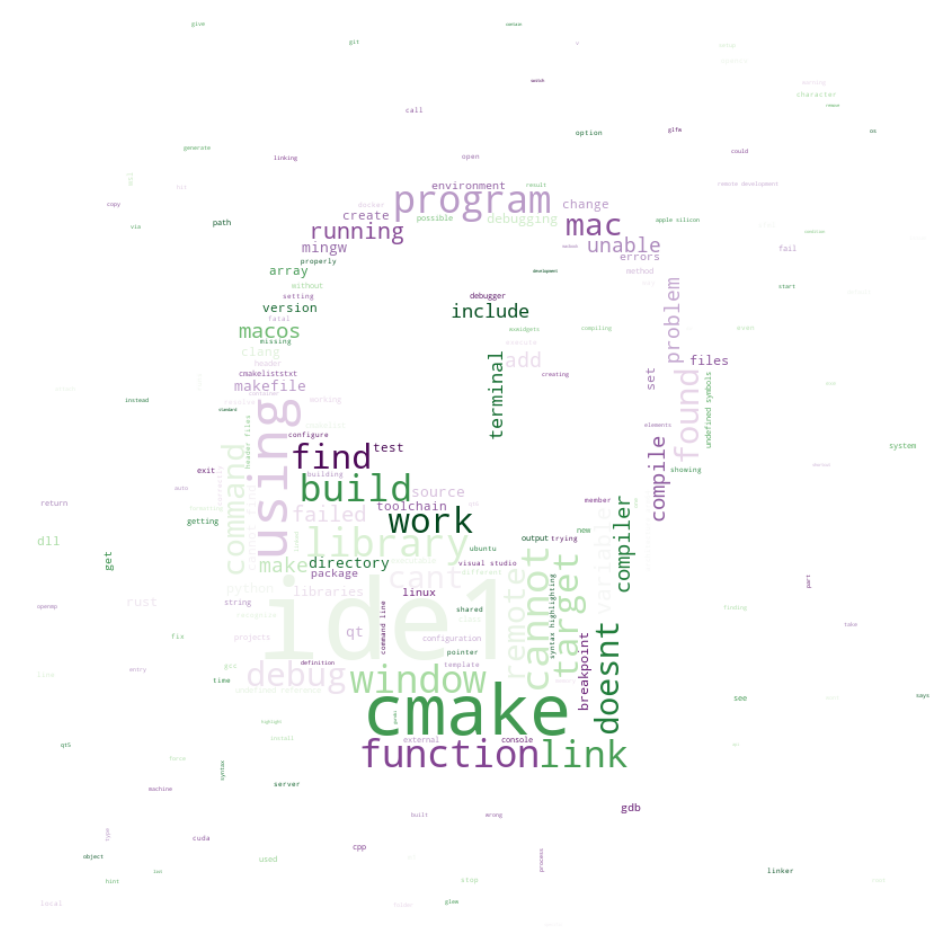

In [ ]:
wc_corpus = " ".join(text for text in posts_data_body["text"])

mask = np.array(Image.open("images/thinking.png"))

wordcloud = WordCloud(
    stopwords=stopwords_list, background_color="white", colormap="PRGn", mask=mask
).generate(wc_corpus)

plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.savefig("images/so_word_cloud.png");

## Finding the most relevant topics

In [13]:
text_data = [text.split() for text in posts_data_body["stemmed"]]

dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

pickle.dump(corpus, open("corpus.pkl", "wb"))
dictionary.save("dictionary.gensim")

ldamodel = gensim.models.ldamodel.LdaModel(
    corpus, num_topics=5, id2word=dictionary, passes=15
)

ldamodel.save("model5.gensim")

topics = ldamodel.print_topics(num_words=8)

for topic in topics:
    print(topic)

(0, '0.132*"ide1" + 0.031*"cmake" + 0.016*"debug" + 0.013*"librari" + 0.013*"link" + 0.011*"find" + 0.011*"fail" + 0.008*"compil"')
(1, '0.070*"ide1" + 0.014*"compil" + 0.012*"work" + 0.012*"window" + 0.012*"found" + 0.010*"find" + 0.009*"function" + 0.008*"take"')
(2, '0.051*"ide1" + 0.015*"cmake" + 0.014*"execut" + 0.013*"configur" + 0.013*"consol" + 0.013*"target" + 0.012*"remot" + 0.012*"doe"')
(3, '0.040*"ide1" + 0.033*"cmake" + 0.015*"compil" + 0.013*"librari" + 0.012*"make" + 0.012*"build" + 0.011*"doe" + 0.011*"function"')
(4, '0.041*"ide1" + 0.016*"header" + 0.016*"cmake" + 0.016*"array" + 0.014*"doesnt" + 0.012*"mac" + 0.012*"creat" + 0.011*"build"')


In [14]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

dictionary = gensim.corpora.Dictionary.load("dictionary.gensim")

corpus = pickle.load(open("corpus.pkl", "rb"))

lda = gensim.models.ldamodel.LdaModel.load("model5.gensim")

lda_display = gensimvis.prepare(lda, corpus, dictionary, sort_topics=False)

pyLDAvis.display(lda_display)

## Main Clusters
- cmake;
- targets and linking libraries;
- headers;
- IDE syntax highlighting;

In [15]:
themes = ["cmake", "target", "highlight", "header"]

theme_titles = pd.DataFrame(index=themes, columns=["Title"])

for word in themes:
    indices = posts_data_body["stemmed"].apply(lambda col: word in col)
    theme_titles.loc[word] = random.choice(
        posts_data_body["Title"].loc[indices].to_list()
    )

theme_titles.head()

,Title
cmake,Can't bind OpenCV to my project via CMake in i...
target,"How to circumvent ""This file does not belong t..."
highlight,ide-1 no syntax highlighting and hints for CMa...
header,"ide-1, C-header files"


In [16]:
print(theme_titles.to_markdown())

|           | Title                                                                |
|:----------|:---------------------------------------------------------------------|
| cmake     | Can't bind OpenCV to my project via CMake in ide-1                   |
| target    | How to circumvent "This file does not belong to any project target"? |
| highlight | ide-1 no syntax highlighting and hints for CMakeLists                |
| header    | ide-1, C-header files                                                |
